In [78]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

# Используем методы cv2.threshold, cv2.morphologyEx и cv2.dilate()(использование порога для  яркости пикселей)

In [ ]:
img = cv2.imread('pryazha_rowan_cashmere_tweed_25g_0005.jpg')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

In [ ]:
plt.imshow(img)

In [ ]:
# Вычисляем маску фона
_, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

# Убираем шум
kernel = np.ones((2, 2), np.uint8)
opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=50)

# создаем маску фона
sure_bg = cv2.dilate(opening, kernel, iterations=20)

In [ ]:
plt.imshow(sure_bg)

# Поиск форм
Метод заключается в том,чтобы  не искать фон и пытаться его удалить, а пытаться найти на изображении самый большой по площади контур и принять его за наш объект.


In [ ]:
def process(img):
    work_img = img.copy()

    # считаем маску
    _, threshold = cv2.threshold(work_img, 30, 200, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    # ищем на маске контуры
    contours, hierarchy = cv2.findContours(threshold, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    max_area = 0
    max_contour = []

    # ищем самый большой из найденных контуров
    for cnt in contours:
        approx = cv2.approxPolyDP(cnt, 0.01 * cv2.arcLength(cnt, True), True)

        cnt_area = cv2.contourArea(cnt)
        # обязательно проверяем кол-во точек.
        # Иначе, часто, получается что самая большая фигура -
        # это треугольник через всю диагональ изображения
        if len(approx) > 3 and cnt_area > max_area:
            max_area = cnt_area
            max_contour = approx

    # рисуем самый большой контур на изображении
    cv2.drawContours(work_img, [max_contour], 0, (255, 0, 0), 2)

    return work_img, threshold

In [ ]:
work_img, threshold = process(gray)
plt.imshow(work_img)
plt.show()
plt.imshow(threshold)
plt.show()

# OpenCV GrabCut
Алгоритм GrabCut работает следующим образом:

На вход подается входное изображения либо с ограничительной рамкой, указывающей местоположение объекта на изображении, которое мы хотели сегментировать, либо с маской, которая аппроксимировала сегментацию. Потом итеративно выполняются следующие шаги:

Шаг № 1: Оценка цветового распределения переднего плана и фона с помощью модели Gaussian Mixture Model

Шаг № 2: Построение марковского случайного поля по меткам пикселей (т. Е. Передний план против фона)

Шаг № 3: Применение оптимизации разреза графа для получения окончательной сегментации


In [ ]:
image_bgr = cv2.imread('pryazha_rowan_cashmere_tweed_25g_0005.jpg')
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

rectangle = (0, 0, 865, 865)
# 600, 550, 1150, 2000
mask = np.zeros(image_rgb.shape[:2], np.uint8)

bgdModel = np.zeros((1, 65), np.float64)
fgdModel = np.zeros((1, 65), np.float64)

cv2.grabCut(image_rgb, mask, rectangle, bgdModel, fgdModel, 5, cv2.GC_INIT_WITH_RECT)

mask_2 = np.where((mask == 2) | (mask == 0), 0, 1).astype('uint8')

image_rgd_nobg = image_rgb * mask_2[:, :, np.newaxis]

plt.imshow(image_rgd_nobg), plt.axis('off')
plt.show()

# Использование предобученной модели для отделение объекта от фона

In [1]:
import torch
import numpy as np
model = torch.hub.load('pytorch/vision:v0.10.0', 'deeplabv3_resnet50', pretrained=True)
model.eval()

Using cache found in C:\Users\user/.cache\torch\hub\pytorch_vision_v0.10.0


DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

In [2]:
# предобработка данных 
from PIL import Image
from torchvision import transforms
input_image = Image.open('data/train_images/0d1a9caf4350_04.jpg')
input_image = input_image.convert("RGB")
preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

input_tensor = preprocess(input_image)
input_batch = input_tensor.unsqueeze(0) # создадим mini-batch

# переместим изображение и модель в GPU , если это возможно:

if torch.cuda.is_available():
    input_batch = input_batch.to('cuda')
    model.to('cuda')

with torch.no_grad():
    output = model(input_batch)['out'][0]
output_predictions = output.argmax(0)

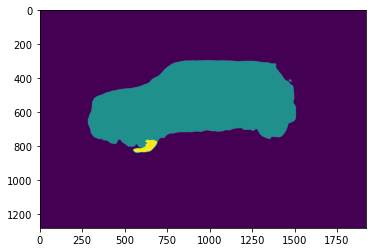

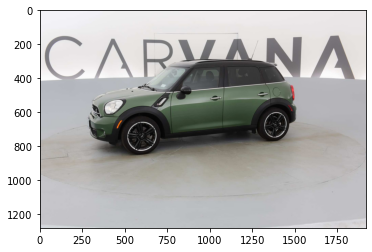

In [3]:
# create a color pallette, selecting a color for each class
palette = torch.tensor([2 ** 25 - 1, 2 ** 15 - 1, 2 ** 21 - 1])
colors = torch.as_tensor([i for i in range(21)])[:, None] * palette
colors = (colors % 255).numpy().astype("uint8")

# plot the semantic segmentation predictions of 21 classes in each color
r = Image.fromarray(output_predictions.byte().cpu().numpy()).resize(input_image.size)

import matplotlib.pyplot as plt
plt.imshow(r)
plt.show()
plt.imshow(input_image)

In [82]:
def remove(mask,input_image):
    mask = np.array(mask)
    mask = np.expand_dims(mask,2)
    image =  np.array(input_image)
    D = np.concatenate((mask,mask,mask),2)
    D = np.where(D != 0, image , 0)
    return D

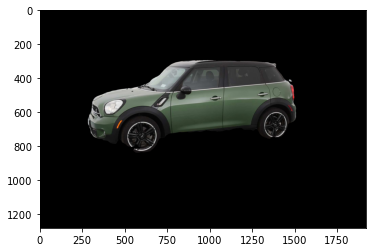

In [5]:
cleared = remove(r,input_image)
plt.imshow(cleared)

# Вычисление  метрик для DeepLabv3

In [27]:
deeplabv3_transforms = A.Compose(
        [
            A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
            A.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
                max_pixel_value=255.0,
            ),
            ToTensorV2(),
        ],
    )
        
            
train_loader, val_loader = get_loaders(
        TRAIN_IMG_DIR,
        TRAIN_MASK_DIR,
        VAL_IMG_DIR,
        VAL_MASK_DIR,
        BATCH_SIZE,
        deeplabv3_transforms,
        deeplabv3_transforms,
        NUM_WORKERS,
        PIN_MEMORY,
    )
            
check_accuracy_deeplabv3(val_loader, model, device=DEVICE)

Got 25195530/28876800 with acc 87.25
Dice score: 0.6000761389732361


# U-Net
Для обучения была выбрана архитектура U-net (описанная в статье https://arxiv.org/abs/1505.04597), так как

1)Имеет хорошую производительности в различных реальных задачах, особенно в биомедицинском применении.

2)Вычислительная сложность.

3)Использует небольшое количество данных для достижения хороших результатов.

4)Наличие большого количества информации в интернете

В качестве дата сета возьмем изображения автомобилей, каждый автомобиль имеет ровно 16 изображений, каждое из которых сделано под разными углами. (https://www.kaggle.com/competitions/carvana-image-masking-challenge/data?select=train_masks.zip) 

В качестве метрик были выбраны Dice score и Pixel Accuracy


Другие найденые датасеты:

PASCAL VOC является одним из самых популярных наборов данных в компьютерном зрении, с аннотированными изображениями, доступными для 5 задач — классификации, сегментации, обнаружения, распознавания действий .
Для задач сегментации PASCAL VOS поддерживает 21 класс меток объектов: транспортные средства, домашнее хозяйство, животные, самолет, велосипед, лодка, автобус, автомобиль, мотоцикл, поезд, бутылка, стул, обеденный стол, горшечное растение, диван, телевизор / монитор, птица, кошка, корова, собака, лошадь, овца и человек.Пиксели помечаются как фоновые, если они не принадлежат ни к одному из этих классов. Данные обучения/проверки PASCAL VOC содержат 11'530 изображений, содержащих 27'450 аннотированных объектов ROI и 6'929 сегментаций.


.Cityscapes - большой датасет ориентирован на семантическое понимание городских уличных сцен. Он содержит разнообразный набор стереовидеопоследовательностей, записанных на улицах 50 городов, 5000 полностью аннотированных изображений и набор из 20 000 слабо аннотированных кадров. Кроме того, время сбора охватывает несколько месяцев, включая сезоны весны, лета и осени. Городские пейзажи включают семантические и плотные пиксельные аннотации 30 классов, сгруппированных в 8 категорий (плоские поверхности, люди, транспортные средства, конструкции, объекты, природа, небо и пустота).

ADE20K содержит более 20 000 сценоцентрических изображений, аннотированных объектами и частями объектов, и обеспечивает 150 семантических категорий. В отличие от других наборов данных, ADE20K включает в себя маску сегментации объектов и маску сегментации частей. В обучающем наборе 20 210 изображений, в проверочном наборе — 2 000 изображений, а в тестовом наборе — 3 000 изображений.

SUN database - 16’873 олностью аннотированных изображений


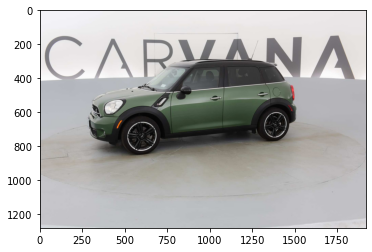

In [4]:
import os
from PIL import Image
from torch.utils.data import Dataset
import numpy as np
import torchvision

class CarvanaDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.images = os.listdir(image_dir)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        img_path = os.path.join(self.image_dir, self.images[index])
        mask_path = os.path.join(self.mask_dir, self.images[index].replace(".jpg", "_mask.gif"))
        image = np.array(Image.open(img_path).convert("RGB"))
        mask = np.array(Image.open(mask_path).convert("L"), dtype=np.float32)
        mask[mask == 255.0] = 1.0

        if self.transform is not None:
            augmentations = self.transform(image=image, mask=mask)
            image = augmentations["image"]
            mask = augmentations["mask"]

        return image, mask

image = Image.open('data/train_images/0d1a9caf4350_04.jpg')
plt.imshow(image)

In [22]:
from torch.utils.data import DataLoader

def save_checkpoint(state, filename="my_checkpoint.pth.tar"):
    print("=> Saving checkpoint")
    torch.save(state, filename)

def load_checkpoint(checkpoint, model):
    print("=> Loading checkpoint")
    model.load_state_dict(checkpoint["state_dict"])

def get_loaders(
    train_dir,
    train_maskdir,
    val_dir,
    val_maskdir,
    batch_size,
    train_transform,
    val_transform,
    num_workers=4,
    pin_memory=True,
):
    train_ds = CarvanaDataset(
        image_dir=train_dir,
        mask_dir=train_maskdir,
        transform=train_transform,
    )

    train_loader = DataLoader(
        train_ds,
        batch_size=batch_size,
        num_workers=num_workers,
        pin_memory=pin_memory,
        shuffle=True,
    )

    val_ds = CarvanaDataset(
        image_dir=val_dir,
        mask_dir=val_maskdir,
        transform=val_transform,
    )

    val_loader = DataLoader(
        val_ds,
        batch_size=batch_size,
        num_workers=num_workers,
        pin_memory=pin_memory,
        shuffle=False,
    )

    return train_loader, val_loader

def check_accuracy_deeplabv3(loader, model, device="cuda"):
    num_correct = 0
    num_pixels = 0
    dice_score = 0
    model.eval()

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            y = y.to(device).unsqueeze(1)
            preds = torch.sigmoid(model(x)['out'][0].argmax(0))
            preds = (preds > 0.5).float()
            num_correct += (preds == y).sum()
            num_pixels += torch.numel(y)
            dice_score += (2 * (preds * y).sum()) / (
                (preds + y).sum() + 1e-8
            )
    print(
        f"Got {num_correct}/{num_pixels} with acc {num_correct/num_pixels*100:.2f}"
    )
    print(f"Dice score: {dice_score/len(loader)}")
    #model.train()

def check_accuracy(loader, model, device="cuda"):
    num_correct = 0
    num_pixels = 0
    dice_score = 0
    model.eval()

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            y = y.to(device).unsqueeze(1)
            preds = torch.sigmoid(model(x))
            preds = (preds > 0.5).float()
            num_correct += (preds == y).sum()
            num_pixels += torch.numel(preds)
            dice_score += (2 * (preds * y).sum()) / (
                (preds + y).sum() + 1e-8
            )

    print(
        f"Got {num_correct}/{num_pixels} with acc {num_correct/num_pixels*100:.2f}"
    )
    print(f"Dice score: {dice_score/len(loader)}")
    model.train()

def save_predictions_as_imgs(
    loader, model, folder="saved_images/", device="cuda"
):
    model.eval()
    for idx, (x, y) in enumerate(loader):
        x = x.to(device=device)
        with torch.no_grad():
            preds = torch.sigmoid(model(x))
            preds = (preds > 0.5).float()
        torchvision.utils.save_image(
            preds, f"{folder}/pred_{idx}.png"
        )
        torchvision.utils.save_image(y.unsqueeze(1), f"{folder}{idx}.png")

    model.train()

In [2]:
import torch
import torch.nn as nn
import torchvision.transforms.functional as TF

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.conv(x)

class UNET(nn.Module):
    def __init__(
            self, in_channels=3, out_channels=1, features=[64, 128, 256, 512],
    ):
        super(UNET, self).__init__()
        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Нижняя часть UNET
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature

        # Верхняя часть UNET
        for feature in reversed(features):
            self.ups.append(
                nn.ConvTranspose2d(
                    feature*2, feature, kernel_size=2, stride=2,
                )
            )
            self.ups.append(DoubleConv(feature*2, feature))

        self.bottleneck = DoubleConv(features[-1], features[-1]*2)
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []

        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx//2]

            if x.shape != skip_connection.shape:
                x = TF.resize(x, size=skip_connection.shape[2:])

            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx+1](concat_skip)

        return self.final_conv(x)

def test():
    x = torch.randn((3, 1, 161, 161))
    model = UNET(in_channels=1, out_channels=1)
    preds = model(x)
    assert preds.shape == x.shape

In [3]:
 test()

In [20]:
import torch
import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim

# Hyperparameters 
LEARNING_RATE = 1e-4
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 16
NUM_EPOCHS = 3
NUM_WORKERS = 0
IMAGE_HEIGHT = 160  # 1280 изначально
IMAGE_WIDTH = 240  # 1918 изначально
PIN_MEMORY = True
LOAD_MODEL = False
TRAIN_IMG_DIR = "data/train_images/"
TRAIN_MASK_DIR = "data/train_masks/"
VAL_IMG_DIR = "data/val_images/"
VAL_MASK_DIR = "data/val_masks/"

def train_fn(loader, model, optimizer, loss_fn, scaler):
    loop = tqdm(loader)

    for batch_idx, (data, targets) in enumerate(loop):
        data = data.to(device=DEVICE)
        targets = targets.float().unsqueeze(1).to(device=DEVICE)

        # forward
        with torch.cuda.amp.autocast():
            predictions = model(data)
            loss = loss_fn(predictions, targets)

        # backward
        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        loop.set_postfix(loss=loss.item())


In [37]:
    train_transform = A.Compose(
        [
            A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
            A.Rotate(limit=35, p=1.0),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.1),
            A.Normalize(
                mean=[0.0, 0.0, 0.0],
                std=[1.0, 1.0, 1.0],
                max_pixel_value=255.0,
            ),
            ToTensorV2(),
        ],
    )

    val_transforms = A.Compose(
        [
            A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
            A.Normalize(
                mean=[0.0, 0.0, 0.0],
                std=[1.0, 1.0, 1.0],
                max_pixel_value=255.0,
            ),
            ToTensorV2(),
        ],
    )

    model = UNET(in_channels=3, out_channels=1).to(DEVICE)
    loss_fn = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

    train_loader, val_loader = get_loaders(
        TRAIN_IMG_DIR,
        TRAIN_MASK_DIR,
        VAL_IMG_DIR,
        VAL_MASK_DIR,
        BATCH_SIZE,
        train_transform,
        val_transforms,
        NUM_WORKERS,
        PIN_MEMORY,
    )

    if LOAD_MODEL:
        load_checkpoint(torch.load("my_checkpoint.pth.tar"), model)


    check_accuracy(val_loader, model, device=DEVICE)
    scaler = torch.cuda.amp.GradScaler()

    for epoch in range(NUM_EPOCHS):
        train_fn(train_loader, model, optimizer, loss_fn, scaler)


        checkpoint = {
            "state_dict": model.state_dict(),
            "optimizer":optimizer.state_dict(),
        }
        save_checkpoint(checkpoint)
        print('test_metrics')
        # вычесление метрик
        check_accuracy(val_loader, model, device=DEVICE)
        print('train_metrics')
        check_accuracy(train_loader, model, device=DEVICE)
        # сохраним несколько примеров
        save_predictions_as_imgs(
            val_loader, model, folder="saved_images/", device=DEVICE
        )

Got 22825206/28876800 with acc 79.04
Dice score: 0.0


100%|██████████| 271/271 [05:33<00:00,  1.23s/it, loss=0.135]


=> Saving checkpoint
test_metrics
Got 28529231/28876800 with acc 98.80
Dice score: 0.9719613790512085
train_metrics
Got 164680200/166502400 with acc 98.91
Dice score: 0.9743160605430603


100%|██████████| 271/271 [04:56<00:00,  1.09s/it, loss=0.084] 


=> Saving checkpoint
test_metrics
Got 28591605/28876800 with acc 99.01
Dice score: 0.9771063327789307
train_metrics
Got 164890889/166502400 with acc 99.03
Dice score: 0.9772245287895203


100%|██████████| 271/271 [05:00<00:00,  1.11s/it, loss=0.06]  


=> Saving checkpoint
test_metrics
Got 28620041/28876800 with acc 99.11
Dice score: 0.9792378544807434
train_metrics
Got 165281603/166502400 with acc 99.27
Dice score: 0.9827645421028137


In [ ]:
print('y_pred')
pred = cv2.imread('saved_images/pred_46.png')
plt.imshow(masks)
plt.show()
print('y_true')
true = cv2.imread('saved_images/46.png')
plt.imshow(masks)

In [43]:
torch.save(model, "data/u-net")
